The following code is to check adversarial attached on different neural networks. The following tutorials or codes have been very useful during the development: 
    
    https://github.com/PetraVidnerova/rbf_keras
    https://keras.io/layers/writing-your-own-keras-layers/
    https://nextjournal.com/gkoehler/digit-recognition-with-keras
    https://fairyonice.github.io/Generate-adversarial-examples-using-TensorFlow.html
    https://www.anishathalye.com/2017/07/25/synthesizing-adversarial-examples/
    https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/
    

In [1]:
import tensorflow as tf

import numpy as np

import pandas as pd

import os

import matplotlib.pyplot as plt 
%matplotlib inline

import gzip
import _pickle as cPickle


import sklearn
from sklearn import datasets
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale


from IPython import display

from keras.models import Sequential, load_model, Model
from keras.layers.core import Dense
from keras.optimizers import RMSprop
from keras import backend as K
from keras.engine.topology import Layer
from keras.initializers import RandomUniform, Initializer, Orthogonal, Constant
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.datasets import mnist
from keras.layers import Conv2D, Flatten, MaxPooling2D

from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io

import math
import random 
import time

Using TensorFlow backend.


In [2]:
#_____initializer for RBF
class InitCentersKmean(Initializer):
    """ Initializer for initialization of centers of RBF network
        using K-mean.

    # Arguments
        X: matrix, dataset to choose the centers from (random rows 
          are taken as centers)
    """
    def __init__(self, X):
        self.X = X
        print("_____ initializing center using InitCentersKmean _____")

    def __call__(self, shape, dtype=None):
        # "shape" is the input_shape for "self.add_weigh" down below
        self.center = sklearn.cluster.k_means(self.X, init='random', n_clusters=shape[0], max_iter = 1, n_jobs=-1)
        
        return self.center[0]

#______ the custom RBF layer        
class RBFLayer(Layer):
    """ Layer of Gaussian RBF units. 

    # Example
 
    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X), 
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```
    

    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas 

    """
   
    def __init__(self, output_dim, betas, initializer, **kwargs):
        self.output_dim = output_dim # dim of the layer's output, i.e. in this case: number of centers in this layer
        self.init_betas = betas 
        self.initializer = initializer 

        super().__init__(**kwargs) #python3 format

    # input shape is the shape from output of last layers. in this case, it's data: [?, 784]
    def build(self, input_shape): 
        self.centers = self.add_weight(name='centers', 
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,), 
                                     initializer=Constant(value=self.init_betas),
                                     trainable=True)
        
        super().build(input_shape) #python3
     
    def call(self, x):

        C=K.expand_dims(self.centers) # shape (ncenter, 784, 1) for broadcast
        H = K.transpose(C-K.transpose(x)) # K.transpose(x) shape (784, ?), then this shape: 

        """
        # the following printout is used for debugging purpose
        print("self.centers.shape: ", self.centers.shape)
        print("x.shape", x.shape)
        print("K.transpose(x).shape: ", K.transpose(x).shape)
        print("C.shape: ", C.shape)
        print("H.shape: ", H.shape)
        print("self.betas.shape: ", self.betas.shape)
        print("K.sum(H**2, axis=-2).shape: ", K.sum(H**2, axis=-2).shape)
        print("call return shape: ", K.exp( -self.betas * K.sum(H**2, axis=-2)).shape)
        """
        a = K.exp( -K.sum(H**2, axis=-2)/(2*self.betas*self.betas))
        
        return a
             

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)


    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        #base_config = super(RBFLayer, self).get_config()
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [3]:
#___ load and normalize mnist data 
def load_mnist_data(n_classes):

    (X_train_raw, Y_train_raw), (X_test_raw, Y_test_raw) = mnist.load_data()
    
    #plt.imshow(X_train_raw[0])
    # Normalizing the input data to max=1 helps to speed up the training. 
    # reshape each image to 1D vector for simplicity
    n_train = X_train_raw.shape[0]
    n_test = X_test_raw.shape[0]
    v_len = X_train_raw.shape[1]*X_train_raw.shape[2]    
    
    X_train = X_train_raw.reshape(n_train, v_len)
    X_test = X_test_raw.reshape(n_test, v_len)
    
    # normalizing the data to help with the training. accurancy is lower than sklearn.preprocessing.scale
    """
    max_pixel = np.max(X_train)
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= max_pixel
    X_test /= max_pixel
    """
    #using sklearn.preprocessing.scale, leads to higher accuracy than normalization by max as above
    X_train = scale(X_train)
    X_test = scale(X_test)

    
    #Do it only when the final layers output is, e.g. 10
    # one-hot encoding using keras' numpy-related utilities
    Y_train = np_utils.to_categorical(Y_train_raw, n_classes)
    Y_test = np_utils.to_categorical(Y_test_raw, n_classes)
    
    return X_train_raw, Y_train_raw, X_test_raw, Y_test_raw, X_train, Y_train, X_test, Y_test

In [4]:
#__ Neural network model
class NN_model():
    def __init__(self, name, X, n_classes, n_center, beta, initializer):
                
        self.model = Sequential()
                    
        if  "RBF" in name: # need to change number of centers in the RBF
            print("++++ using RBF network +++++")
            one_sample_shape = X.shape[-1] # shape for each individual sample

            self.rbflayer = RBFLayer(n_center, beta, 
                                    initializer=initializer(X),
                                    # input_shape is the data shape. The 2nd dim of (one_sample_shape, ) is the number of samples and is treated as ? in keras
                                    input_shape=(one_sample_shape, ), name=name) 

            self.model.add(self.rbflayer)
            self.model.add(Dense(n_classes, name='logits'))
            self.model.add(Activation('softmax'))
        elif name=="dense_1L": 
            print("++++ using 1-hidden layer w/10 neutons dense network +++++")
            self.model.add(Dense(10, input_shape=(784,), name=name))
            self.model.add(Activation('relu'))                            
            #self.model.add(Dropout(0.2))
            self.model.add(Dense(n_classes, name='logits'))
            self.model.add(Activation('softmax'))
        elif name=="dense": 
            print("++++ using 2-hidden layer w/512 neurons dense network +++++")
            self.model.add(Dense(512, input_shape=(784,), name=name))
            self.model.add(Activation('relu'))                            
            #self.model.add(Dropout(0.2))

            self.model.add(Dense(512))
            self.model.add(Activation('relu'))
            #self.model.add(Dropout(0.2))

            self.model.add(Dense(n_classes, name='logits'))
            self.model.add(Activation('softmax'))
        elif name=="CNN_simple": 
            self.model.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation='relu', name=name)) # tf image order: (x, y, channel)
            self.model.add(MaxPooling2D(pool_size=(2, 2)))
            self.model.add(Dropout(0.2))
            self.model.add(Flatten())
            self.model.add(Dense(128, activation='relu'))
            self.model.add(Dense(n_classes, name='logits'))
            self.model.add(Activation('softmax'))
        elif name=="CNN":
            # define the larger model
            self.model.add(Conv2D(16, kernel_size=(3, 3), input_shape=(28, 28, 1), strides=2, activation='relu', name=name))
            self.model.add(Conv2D(32, kernel_size=(3, 3), strides=2, activation='relu'))
            self.model.add(Conv2D(64, kernel_size=(3, 3), strides=2, activation='relu'))
            self.model.add(Flatten()) # flatten the output for the input to dense layer
            self.model.add(Dense(256, activation='relu'))
            self.model.add(Dense(n_classes, name='logits'))
            self.model.add(Activation('softmax'))
        else:
            print("+++++ only option: RBF or dense_1L or dense or CNN_simple or CNN ++++")
            exit()
                             # file and directory for storing weight
        self.weight_dir = 'keras_model_parameter/'
        self.weight_file = self.weight_dir+name+'_weights.h5'
        if not os.path.isdir(self.weight_dir):
            os.mkdir(self.weight_dir)
    
        #self.model.summary()
        self.model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
   
    def outputs(self):
        return self.model.outputs
    
    def inputs(self):
        return self.model.inputs


In [5]:
#__ daughter class of NN_model, focus on functionality
class NN_mnist(NN_model):
    def __init__ (self, name, n_classes, X, Y, X_raw, Y_raw, X_val, Y_val, n_center = 10, initializer=InitCentersKmean, beta=10):
        self.name = name
        
        self.X_raw = X_raw  # input original data 
        self.Y_raw = Y_raw  # input original label         
        self.X = self.reshape_inputs(X)  # input  data after normalization for mean and variance 
        self.Y = Y  # input label after one_hot conversion
        self.X_val = self.reshape_inputs(X_val) # validation data during the model.fit
        self.Y_val = Y_val # validation label during model.fit
               
        print(self.X.shape, self.X_val.shape, "++++")    
        
        super().__init__(name, X, n_classes, n_center, beta, initializer) # initialize parents class
    
    # everything else is the same except the objects included in this function, in this case, self.X, self.X_raw, self.Y_raw
    def __call__(self, X):
        self.X = self.reshape_inputs(X)
        
        return self.get_logits(), self.get_probs()
    
    ## cnn need inputs (nsample, color, x_pixel, y_pixel), dense net need inputs: (nsample, x_pixel, y_pixel)
    def reshape_inputs(self, X):
        if "CNN" in self.name: # CNN need 4-D array inputs
            if X.ndim == 1:  # single image
                X = X.reshape(1, 28, 28, 1).astype('float32') # cnn need inputs (nsample, x_pixel, y_pixel, color)
            elif X.ndim==2: 
                X = X.reshape(X.shape[0], 28, 28, 1).astype('float32')
        else:  # dense net need 2-D inputs
            if X.ndim == 1: # single image
                X = X.reshape(1, X_train.shape[1]).astype('float32')  # dense net need inputs: (nsample, x_pixel*y_pixel)

        return X
    

    # plot the loss and accuracy of the training as a function of epoch
    def plot_training_history(self):
        fig = plt.figure()
        plt.subplot(2,1,1)
        plt.plot(self.history.history['acc'])
        plt.plot(self.history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='lower right')

        plt.subplot(2,1,2)
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')

        plt.tight_layout()

    
    # plot images samples
    def plot(self, indices, n_sample, figsize):
        fig, axes = plt.subplots(3,n_sample,figsize=figsize, subplot_kw={'xticks':[], 'yticks':[]}) #subplot_kw option removes ticks in X, Y axes
        for i in range(n_sample):
            index=indices[i]
            
            #  the original image before the normalization (this should be used for adversarial attacks)
            axes[0, i].imshow(self.X_raw[index], cmap='gray', interpolation='none')
            axes[0, i].set_title("True: {}  predict: {}".format(self.Y_raw[index], self.predicted_classes[index]))

            # normalized image. The background become uneven due to the normalization. Looks like already has ADATK
            a = self.X[index].reshape(28, 28)
            axes[1, i].imshow(a, cmap='gray', interpolation='none')

            # 1-D histogram of normalized image
            if "CNN" in self.name:
                axes[2, i].hist(self.X[index].reshape(28*28), bins=20) 
            else:
                axes[2, i].hist(self.X[index],  bins=20) 

        fig.tight_layout()
        fig.subplots_adjust(hspace=0.01)
    

    # plot image samples include original, normalized. Need to be updated to included ada image later.
    def plot_random_sample(self, X, X_raw, Y_raw, which_to_plot, n_sample = 8, figsize=(15,5)):   
        
        self.X = self.reshape_inputs(X)
        self.X_raw = X_raw
        self.Y_raw = Y_raw
        
        # identify the indices of correctly and incorrectly recognized images
        self.identify_correct_incorrect_prediction()
        
        if which_to_plot == "correct":
            print("__correctly identified image _____")
            indices = np.random.choice(self.correct_indices, size=n_sample) # random indices of correctly identifed images 
        elif which_to_plot == "incorrect":
            print("__wrongly identified image _____")
            indices = np.random.choice(self.incorrect_indices, size=n_sample) # random indices of incorrectly identified images in the data
        else:
            print("___ try again on inputs: correct or incorrect ___")

        self.plot(indices, n_sample, figsize)
        
    # evulated the model
    def eval(self):
        loss_and_metrics = self.model.evaluate(self.X, self.Y, verbose=2) # the metric is defined when compiling the model
        print("__Loss:  ", loss_and_metrics[0])
        print("__Accuracy: ", loss_and_metrics[1])
        
    # identify correct or incorrect prediction indices which is used for plotting later
    def identify_correct_incorrect_prediction(self): 
        print("___ calculating the correct and incorrect prediction _____")
        self.predicted_classes = np.argmax(self.model.predict(self.X), axis=-1)
        self.correct_indices = np.nonzero(self.predicted_classes == self.Y_raw)[0]
        self.incorrect_indices = np.nonzero(self.predicted_classes != self.Y_raw)[0]
        print("__complete___")
        
            # run the model, save the weight and plot the training history
    def run(self, batch_size=100, epochs=1, verbose=2):
        self.history = self.model.fit(self.X, self.Y,
                                      batch_size,
                                      epochs,
                                      verbose,
                                      validation_data=(self.X_val, self.Y_val))
        # saving the model
        """
        # loading model has problem this way. it complain RBF layer is not unknow. 
        save_dir = "./results/"
        model_name = 'RBF.h5'
        model_path = os.path.join(save_dir, model_name)
        model.save(model_path)
        print('Saved trained model at %s ' % model_path)
        """
        print("___ saving the model weight____")    
        self.model.save_weights(self.weight_file)
                
        # plot the history of the training 
        self.plot_training_history()
        
    # load the model weight. Currently the can not save the entire model since it compile RBFlayer is not defined
    def load_model(self): 
        if os.path.exists(self.weight_file):
            self.model.load_weights(self.weight_file)
        else:
            print("++++ no model weight file: ", self.weight_file, "can be found ++++")
            exit()


    # get output from a layers. In this case, for logits
    def get_logits(self):

        self.logits_layer_model = Model(inputs=self.model.input, outputs=self.model.get_layer('logits').output)
  
        return self.logits_layer_model.predict(self.X)
    
    # get the probability of each class
    def get_probs(self):
        return self.model.predict(self.X)


C:\Users\wxie\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


(60000, 28, 28, 1) (10000, 28, 28, 1) ++++
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 6s 103us/step - loss: 0.2657 - acc: 0.9209 - val_loss: 0.0857 - val_acc: 0.9740
Epoch 2/20
60000/60000 [==============================] - 6s 96us/step - loss: 0.0744 - acc: 0.9771 - val_loss: 0.0634 - val_acc: 0.9814
Epoch 3/20
60000/60000 [==============================] - 6s 102us/step - loss: 0.0499 - acc: 0.9846 - val_loss: 0.0542 - val_acc: 0.9831
Epoch 4/20
60000/60000 [==============================] - 6s 99us/step - loss: 0.0386 - acc: 0.9877 - val_loss: 0.0495 - val_acc: 0.9859
Epoch 5/20
60000/60000 [==============================] - 6s 96us/step - loss: 0.0304 - acc: 0.9908 - val_loss: 0.0479 - val_acc: 0.9864
Epoch 6/20
60000/60000 [==============================] - 6s 98us/step - loss: 0.0237 - acc: 0.9921 - val_loss: 0.0514 - val_acc: 0.9847
Epoch 7/20
60000/60000 [==============================] - 6s 98us/step - loss: 0.02

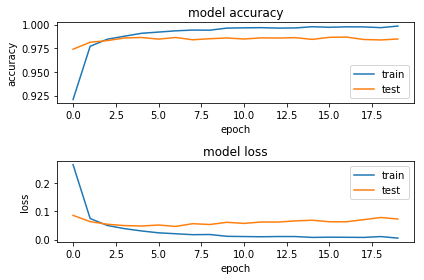

In [6]:
#+++++++++++ input parameters for running the model ++++++++++
model_ID = 6
is_training = True   # training or loading a model
epochs=20

batch_size=100 
verbose=1 # printout information
n_classes = 10 # number of digits 0-9
n_center = 0  # needed only by RBF
beta = 0 # needed only by RBF

if model_ID ==1:
    model_name = "dense_1L"
elif model_ID ==2:
    model_name = "dense"
elif model_ID==3:
    n_center = 10
    beta = 10
    model_name = "RBF_10center"
elif model_ID==4:
    n_center = 50
    beta = 10
    model_name = "RBF_50center"
elif model_ID==5:
    model_name = "CNN_simple"
elif model_ID==6:
    model_name = "CNN"

#load the mnist data
X_train_raw, Y_train_raw, X_test_raw, Y_test_raw, X_train, Y_train, X_test, Y_test = load_mnist_data(n_classes)

# the model
model = NN_mnist(model_name, n_classes,  X_train, Y_train, X_train_raw, Y_train_raw, X_test, Y_test, n_center, InitCentersKmean, beta)

# train or load the model
if is_training:
    model.run(batch_size, epochs, verbose)
else:
    model.load_model()

model.eval()

___ calculating the correct and incorrect prediction _____
__complete___
__wrongly identified image _____


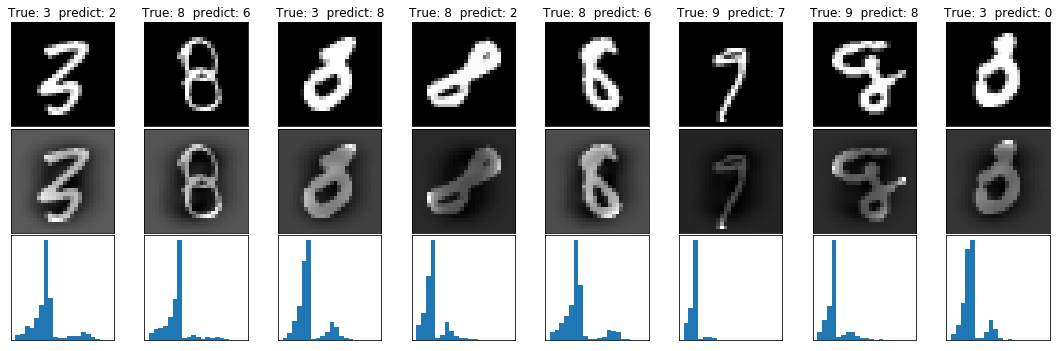

In [7]:
# this is the training sample
model.plot_random_sample(X_train, X_train_raw, Y_train_raw, "incorrect")

___ calculating the correct and incorrect prediction _____
__complete___
__correctly identified image _____


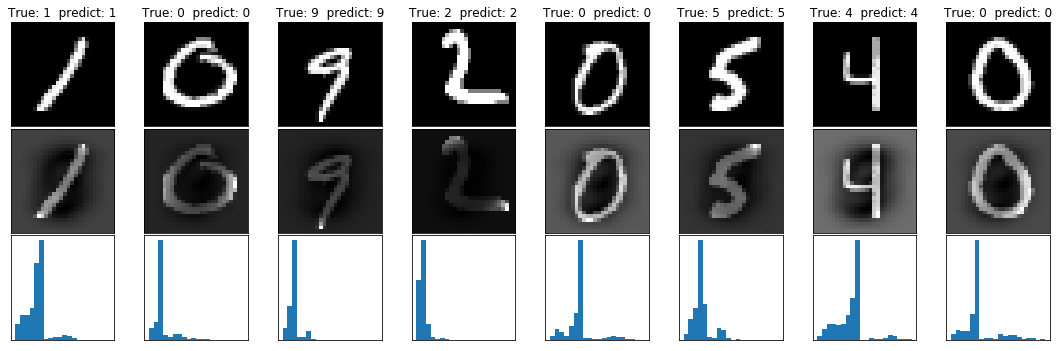

In [8]:
# this is the test sample 
model.plot_random_sample(X_test, X_test_raw, Y_test_raw, "correct")

In [9]:
# Write the graph in binary .pb file. Convert keras model to a tensorflow model
outdir = "keras_to_TF"
try:
    os.mkdir(outdir )
except:
    pass

prefix = model_name 
name = prefix+'_output_graph.pb' # Alias the outputs in the model - this sometimes makes them easier to access in TF

pred = []
pred_node_names = []
for i, o in enumerate(model.outputs()):
        pred_node_names.append(prefix+'_'+str(i))
        pred.append(tf.identity(o, name=pred_node_names[i]))
print('Output nodes names are: ', pred_node_names[0])

if is_training: # converting keras model to TF model
    sess = K.get_session()
    constant_graph = graph_util.convert_variables_to_constants(sess, 
                                                               sess.graph.as_graph_def(), 
                                                               pred_node_names)
    graph_io.write_graph(constant_graph, outdir, name, as_text=False)
    ## Finally delete the Keras's session
    #K.clear_session() # somehow doesn't work for CNN
    
#load the tensorflow model from the file
#tf.reset_default_graph() # somehow doesn't work for CNN

def load_graph(model_name):
    graph = tf.get_default_graph()
    graph_def = tf.GraphDef()
    with open(model_name, "rb") as f:
        graph_def.ParseFromString(f.read())
    with graph.as_default():
        tf.import_graph_def(graph_def)
    return graph


Output nodes names are:  CNN_0
INFO:tensorflow:Froze 10 variables.
Converted 10 variables to const ops.


In [10]:

# print out the operation name for double check. No need to run if one is sure about the name of the operation
for i, op in enumerate(tf.get_default_graph().get_operations()):
    print ("{: 3.0f}: {}".format(i,op.name))


  0: CNN_input
  1: CNN/random_uniform/shape
  2: CNN/random_uniform/min
  3: CNN/random_uniform/max
  4: CNN/random_uniform/RandomUniform
  5: CNN/random_uniform/sub
  6: CNN/random_uniform/mul
  7: CNN/random_uniform
  8: CNN/kernel
  9: CNN/kernel/Assign
 10: CNN/kernel/read
 11: CNN/Const
 12: CNN/bias
 13: CNN/bias/Assign
 14: CNN/bias/read
 15: CNN/convolution/dilation_rate
 16: CNN/convolution
 17: CNN/BiasAdd
 18: CNN/Relu
 19: conv2d_1/random_uniform/shape
 20: conv2d_1/random_uniform/min
 21: conv2d_1/random_uniform/max
 22: conv2d_1/random_uniform/RandomUniform
 23: conv2d_1/random_uniform/sub
 24: conv2d_1/random_uniform/mul
 25: conv2d_1/random_uniform
 26: conv2d_1/kernel
 27: conv2d_1/kernel/Assign
 28: conv2d_1/kernel/read
 29: conv2d_1/Const
 30: conv2d_1/bias
 31: conv2d_1/bias/Assign
 32: conv2d_1/bias/read
 33: conv2d_1/convolution/dilation_rate
 34: conv2d_1/convolution
 35: conv2d_1/BiasAdd
 36: conv2d_1/Relu
 37: conv2d_2/random_uniform/shape
 38: conv2d_2/random

In [11]:
# the tensorflow model. All one needs are input and output operation and logits operation.  
# load the model
my_graph = load_graph(model_name=os.path.join(outdir, name))

# note: need to add "import" in the option name, otherwise, the keras model and TF model outputs are different
input_op = my_graph.get_operation_by_name("import/"+model_name+"_input") # name of input operation 
output_op = my_graph.get_operation_by_name("import/"+pred_node_names[0]) # name of output operation
logit_op = my_graph.get_operation_by_name("import/logits/BiasAdd") # name of logits operation. Double checked from keras model output

ops = (input_op,output_op, logit_op)

print(input_op.outputs[0].shape)
print(output_op.outputs[0].shape)

(?, 28, 28, 1)
(?, 10)


In [12]:
# generate adversarial image  
class AdversarialImage(object):
    def __init__(self, inp, out, logits, name):
        '''
        inp : input tensor  (image)
        out : output tensor (y_pred)
        eps : scalar
        '''
        self.inp = inp.outputs[0] # input tensor
        self.out = out.outputs[0] # output tensor
        self.logits = logits.outputs[0] # logits tensor
        self.name = name # name of the saved file. 
    
    ## cnn need inputs (nsample, color, x_pixel, y_pixel), dense net need inputs: (nsample, x_pixel, y_pixel)
    def reshape_inputs(self, X):
        if "CNN" in self.name: # CNN need 4-D array inputs
            if X.ndim == 1:  # single image
                X = X.reshape(1, 28, 28, 1).astype('float32') # cnn need inputs (nsample, x_pixel, y_pixel, color)
            elif X.ndim==2: 
                X = X.reshape(X.shape[0], 28, 28, 1).astype('float32')
        else:  # dense net need 2-D inputs
            if X.ndim == 1: # single image
                #X = X.reshape(1, X.shape[0]).astype('float32')  # dense net need inputs: (nsample, x_pixel*y_pixel)
                X = X.reshape(1, X.shape[0])  # dense net need inputs: (nsample, x_pixel*y_pixel)

        return X
    

    # obtain adversarial image
    def get_adv_image(self, image, goal_class, nsteps, eps=1, beta = 0.01, verbose=0):
        """
        image: original image 
        goal_class:  the goal class of the adversarial prediction from 0-9 
        nsteps: number of steps to perform gradient descent
        eps: learning rate 
        beta: learning rate for the 2nd term in the loss
        verbose: 0: loss, 1: prob, logistic, loss
        
        """
        image = self.reshape_inputs(image) # make sure the dim is (nsample, image)
        org_image = image # for the 2nd term of the loss 
        
        y_goal_tf = tf.expand_dims(tf.one_hot(goal_class, n_classes), axis=0) # the expansion take care of the nsample dimension
        y_pred_tf = self.logits 

        #adv_image = self.inp - eps*grad_tf # adversarial image tensor going along the gradient direction    
        org_image_tf = tf.placeholder(tf.float32, shape=image.shape)
        
        # this loss is a lot more effective than MSE loss function
        loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred_tf, labels=[y_goal_tf])
        grad_tf  = tf.gradients(loss, self.inp)[0] # gradients of loss w.r.t. the image

        #adv_image = tf.zeros(image.shape)
        adv_image = self.inp
        noise_image = tf.zeros(image.shape) # noise added on to the original image
        
        noise_per_step = eps*(grad_tf + beta*(adv_image - org_image_tf))
        
        adv_image -= noise_per_step   # adversarial image tensor going along the gradient direction        
        noise_image += noise_per_step
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            # gradient descent
            for i in range(nsteps):
                # need to update image everytime
                adv, noise, vloss, lg, grad, = sess.run([adv_image, noise_image, loss, y_pred_tf,  grad_tf ], 
                                                        feed_dict={self.inp:image, org_image_tf:org_image})
                image = adv # update image every step. the updated image is fed to the self.inp
                
                if verbose != 0:
                    print("loss: ", vloss)
                    print("grad: ", grad[0][0:10])
                    print("logitis:", lg)

                if(i%200 == 0):
                    print("loss: ", vloss)
                 
        return adv, noise # numpy arrage of image
    
    # model prediction of the input image X. can be the original or the adv_image
    def predict(self, image):
        """
        image: input image
        
        """
        image = self.reshape_inputs(image) # check to make the input image shape is (nsample, image)
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            logits, probs = sess.run([self.out, self.logits], feed_dict={self.inp:image})
            
        return probs, logits

    # draw input image together with the probability of the image
    def plot(self, input_images, correct_class, goal_class, figsize=(22, 3)):
        """
        input_images[0]:--> orignial image
        input_images[1]:--> adversarial image
        input_images[2]:--> added noise, i.e. adv_image - org_image
        correct_class:--> correct label
        goal_class:--> goal label for adversarial 
    
        """
        num_of_image = len(input_images)
        probs = np.ndarray(shape=(num_of_image, 1, n_classes)) # define an array
        for i in range(num_of_image):
            input_images[i] = self.reshape_inputs(input_images[i]) # check to make the input image shape is (nsample, image)
            _, probs[i] = self.predict(input_images[i]) # probs[i].shape = (1, 10)      
            
        # subplots with nrow rows and ncoll columns
        nrow = 1
        ncoll = 6
        fig, axes = plt.subplots(nrow, ncoll, figsize=figsize)
        
        ith = 0 # index of input_images[]
        for i in range(0, ncoll, 2):  # remove ticks on axes of images
            axes[i].set_xticks([])
            axes[i].set_yticks([])
            axes[i].imshow(input_images[ith].reshape(X_train_raw[0].shape), cmap='gray', interpolation='none')
            ith += 1
            
        ith = 0 # index of probs[]
        for i in range(1, ncoll, 2):  
            barlist = axes[i].bar(range(n_classes), probs[ith][0]) # draw bar in the plot
            ith +=1  

            barlist[goal_class].set_color('r')
            barlist[correct_class].set_color('g')
            
            axes[i].set_ylim([0, 1.1])
            axes[i].set_ylabel('Probility')
            axes[i].set_xticks(range(n_classes))
            axes[i].set_xticklabels(str(i) for i in range(n_classes))
                


In [13]:
adv = AdversarialImage(*ops, name)

In [14]:
# test if the tensorflow model has the same output as the keras model
X = X_train[0]
a, b = model(X)
print(a)
print(b)

c, d = adv.predict(X)
print(c)
print(d)

[[-13.269196   -5.401851  -13.986361   18.741957  -34.54239    22.53922
  -13.317042  -14.85932    -3.1463373  -3.4410899]]
[[2.7476857e-16 7.1731835e-13 1.3412419e-16 2.1939902e-02 1.5853916e-25
  9.7806007e-01 2.6193210e-16 5.6025499e-17 6.8433583e-12 5.0963595e-12]]
[[-13.269196   -5.401851  -13.986361   18.741957  -34.54239    22.53922
  -13.317042  -14.85932    -3.1463373  -3.4410899]]
[[2.7476857e-16 7.1731835e-13 1.3412419e-16 2.1939902e-02 1.5853916e-25
  9.7806007e-01 2.6193210e-16 5.6025499e-17 6.8433583e-12 5.0963595e-12]]


In [17]:
ith = 3  # ith sample in the data
goal_class = 1
nstep = 2000
epsilon = 1
beta = 0.01

org_image = X_test[ith]
correct_class = Y_test_raw[ith]

adv_image, noise_image = adv.get_adv_image(org_image, goal_class, nstep, epsilon, beta)

loss:  [45.569576]
loss:  [0.01447204]
loss:  [0.01390814]
loss:  [0.01491021]
loss:  [0.01398255]
loss:  [0.0143328]
loss:  [0.01437487]
loss:  [0.01362712]
loss:  [0.01361818]
loss:  [0.01392565]


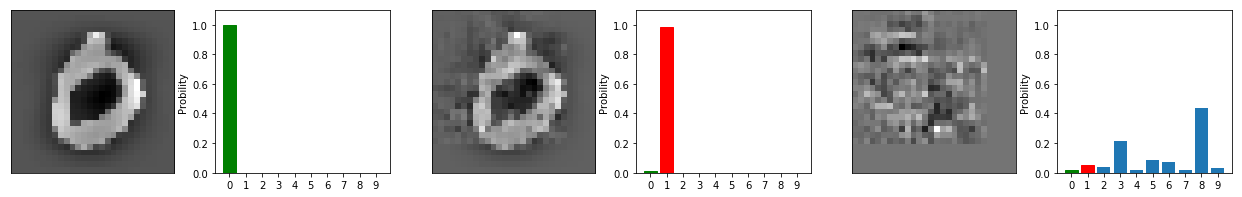

In [18]:
input_images = [org_image, adv_image, noise_image]

adv.plot(input_images, correct_class, goal_class)